- Checking for api key being loaded or not

Data Sample:
            Line               Destination        Date      Time  \
0  Not available  Höga hallar (Härryda kn)  2025-01-21  20:16:00   
1  Not available    Stenared (Göteborg kn)  2025-01-21  20:17:00   
2  Not available  Höga hallar (Härryda kn)  2025-01-21  20:18:00   
3  Not available       Kungälv resecentrum  2025-01-21  20:18:00   
4  Not available  Bockkranen (Göteborg kn)  2025-01-21  20:18:00   

  Transport Type  
0  Not available  
1  Not available  
2  Not available  
3  Not available  
4  Not available  


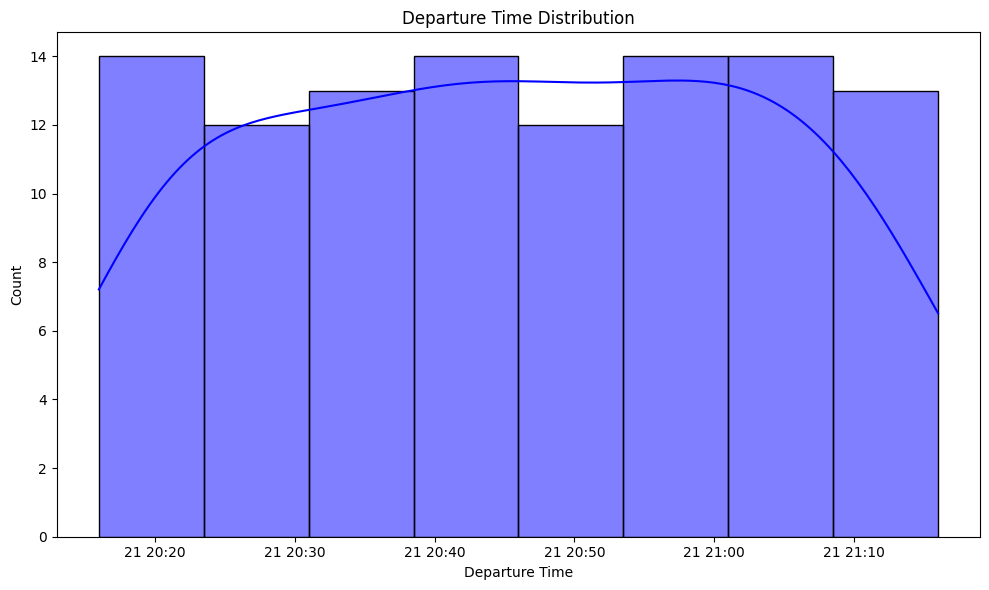

In [9]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv


load_dotenv()
API_KEY = os.getenv("TRAFFICLABS_API_KEY")


def get_departures():
    stop_id = "740000002"  
    base_url = "https://api.resrobot.se/v2.1/departureBoard"
    params = {
        "id": stop_id,
        "format": "json",
        "accessId": API_KEY
    }
    

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        
        departures = []
        for item in data.get("Departure", []):
            departures.append({
                "Line": item.get("transportNumber", "Not available"),  
                "Destination": item.get("direction", "Unknown"),
                "Date": item.get("date", "Unknown"),
                "Time": item.get("time", "Unknown"),
                "Transport Type": item.get("transportCategory", "Not available"),  
            })
        return pd.DataFrame(departures)  
    else:
        print(f"Error: {response.status_code}")
        print(f"Response Text: {response.text}")
        return pd.DataFrame()  


df = get_departures()


if not df.empty:
    print("Data Sample:")
    print(df.head())

    df['Time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
    if not df['Time'].isna().all():
        plt.figure(figsize=(10, 6))
        sns.histplot(df['Time'].dropna(), kde=True, color='blue')
        plt.title("Departure Time Distribution")
        plt.xlabel("Departure Time")
        plt.tight_layout()
        plt.show()
else:
    print("No data available.")
